In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source

from toolbox.pca_plot import get_variance_percentage, get_number_of_attributes, plot_pca_variance
from toolbox.data_processing import clean_data, merge_train_and_test_data,get_y_train_and_test_data
from toolbox.k_fold_algorithm import k_fold, plot_classification_error
from toolbox.plot_results import plot_tree_graph, plot_confusion_matrix, plot_roc_curve, plot_cm_and_rc

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

In [2]:
y = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
train = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
test = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')
y

,cancer
patient,
1,ALL
2,ALL
3,ALL
4,ALL
5,ALL
...,...
68,ALL
69,ALL
70,ALL


In [3]:
train, test, y = clean_data(train, test, y)
# Sort the indexes
train.index = pd.to_numeric(train.index) 
test.index = pd.to_numeric(test.index) 
train.sort_index(inplace=True) 
test.sort_index(inplace=True)

In [4]:
# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']
y_train, y_test = get_y_train_and_test_data(y)
complete_data = merge_train_and_test_data(train, test)
complete_data

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
71,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12


In [5]:
pca = PCA()
pca_data = pca.fit_transform(complete_data)

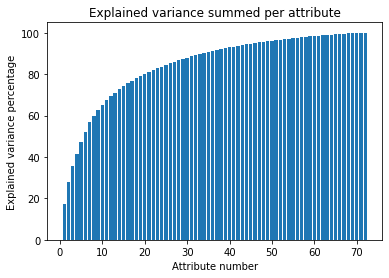

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
    the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 33 attributes that together explain 90% of the variance.


In [6]:
pca_variance_percentage = get_variance_percentage(pca)
no_attributes = get_number_of_attributes(pca_variance_percentage)
plot_pca_variance(pca_variance_percentage, no_attributes)

In [7]:
#Crop pca_data
pca_data = np.delete(pca_data, slice(no_attributes, len(pca_data)) , 1)

#Split data back to original train and test split
pca_train = pca_data[:38]
pca_test = pca_data[38:]

In [8]:
y_np = y.to_numpy()
accuracy_mean_train, accuracy_mean_test = k_fold(pca_data, y_np, 10, 1, 21, 1, 'tree')

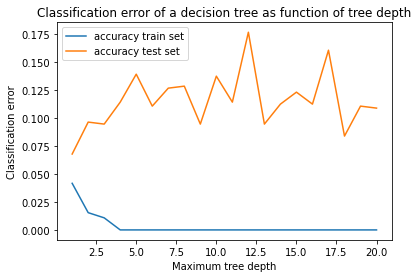

In [9]:
plot_classification_error(1, 21, 1, accuracy_mean_train, accuracy_mean_test, 'tree depth')

In [10]:
tree_complete = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4, min_samples_leaf=5)
tree_complete = tree_complete.fit(pca_train, y_train)
prediction_complete=tree_complete.predict(pca_test)
accuracy_complete = metrics.accuracy_score(y_test, prediction_complete)
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy_complete, 1-accuracy_complete))

The standard decision tree has an accuracy of 0.9411764705882353 and an error rate of 0.05882352941176472.


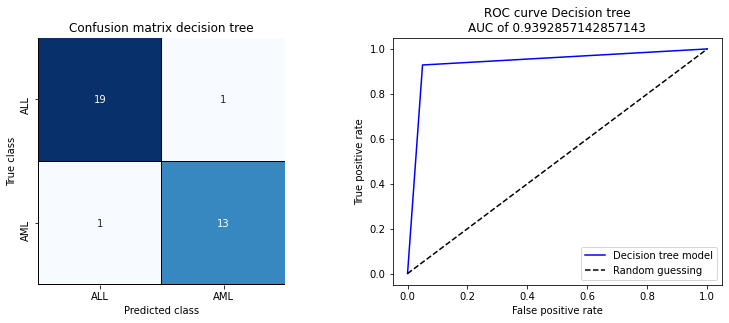

In [16]:
conf_matrix_tree = metrics.confusion_matrix(y_test, prediction_complete)
plot_cm_and_rc(conf_matrix_tree, patient_labels,y_test, prediction_complete,'Decision tree', 'Confusion matrix decision tree')